# <center> Password Difficulty Prediction

__Проблема:__   
Постройть модель, которая на основании размеченных данных будет предсказывать качество пароля, введенного пользователем.
    
__Дополнительные требования:__
- Предусмотреть возможность проверки новых паролей.
- Прокомментировать и обосновать преобразования данных, выбор метода и метрики для оценивания результата предсказания модели.
***
    
У нас есть данные, которые состоят из примеров паролей (password) и их оценок (strength):
- 0 (слабый)
- 1 (средний)
- 2 (сильный)

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels import stats as sms
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

# для нормализации, стандартизации
from sklearn import preprocessing

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Set aspects of the visual theme
sns.set_theme("notebook") # установка предварительных настроек маштабирования
sns.set_palette("husl") # установка предварительной световой палитры

# Analysis/Modeling

In [2]:
# посмотрим данные
df = pd.read_csv('passwords.csv')
display(df)

,password,strength
0,yrtzuab476,1
1,yEdnN9jc1NgzkkBP,2
2,sarita99,1
3,Suramerica2015,2
4,PPRbMvDIxMQ19TMo,2
...,...,...
99995,aulona044,1
99996,5201314ding,1
99997,isaac19725,1
99998,toji25,0


In [3]:
# посмотрим информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  100000 non-null  object
 1   strength  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [4]:
# создадим новые признаки на основе имеющийся информаций
df['digit_len'] = 0 # количество цифр в пароле
df['alpha_len'] = 0 # количество букв в пароле
df['special_symbol_len'] = 0 # количество спец. символов в пароле
df['upper_letter_len'] = 0 # количество больших букв в пароле
df['is_dublicate'] = 0 # количество дубликатов в пароле
df['little_letter_len'] = 0 # количество строчных букв в пароле

In [5]:
# подсчитаем длину пароля, количество больших и прописных букв, цифр, спец. символов 
for i, v in enumerate(df['password']):
    # через генератор подсчитываем количество букв, цифр, спец. символов
    lenght = len(v)
    a = len([x for x in v if x.isalpha()]) # буквы
    u = len([x for x in v if x.isupper()]) # заглавные буквы
    d = len([x for x in v if x.isdigit()]) # цифры
    s = len(v) - (a + d) # спец. символы
    l = len(v) - (u + d + s) #  маленькие буквы
    dub = len([x for j, x in enumerate(v) if j != v.index(x)]) # дубликаты
    df.at[i, 'lenght'] = lenght
    df.at[i, 'digit_len'] = d
    df.at[i, 'alpha_len'] = a
    df.at[i, 'special_symbol_len'] = s
    df.at[i, 'upper_letter_len'] = u
    df.at[i, 'little_letter_len'] = l
    df.at[i, 'is_dublicate'] = dub

In [6]:
# посмотрим информацию
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   password            100000 non-null  object 
 1   strength            100000 non-null  int64  
 2   digit_len           100000 non-null  int64  
 3   alpha_len           100000 non-null  int64  
 4   special_symbol_len  100000 non-null  int64  
 5   upper_letter_len    100000 non-null  int64  
 6   is_dublicate        100000 non-null  int64  
 7   little_letter_len   100000 non-null  int64  
 8   lenght              100000 non-null  float64
dtypes: float64(1), int64(7), object(1)
memory usage: 6.9+ MB


None

In [7]:
# посмотрим размерность
display(df.shape)

(100000, 9)

In [8]:
# Посмотрим статистическую информацию по всем столбцам
display(df.describe(include = 'all'))

,password,strength,digit_len,alpha_len,special_symbol_len,upper_letter_len,is_dublicate,little_letter_len,lenght
count,100000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000
unique,100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,yrtzuab476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.988660,3.18047,6.749010,0.046060,0.789520,1.43215,5.95949,9.975540
std,NaN,0.507044,1.99945,3.090743,0.334215,2.276895,1.34724,2.35646,2.766384
min,NaN,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000
25%,NaN,1.000000,2.00000,5.000000,0.000000,0.000000,0.00000,5.00000,8.000000
50%,NaN,1.000000,3.00000,6.000000,0.000000,0.000000,1.00000,6.00000,9.000000
75%,NaN,1.000000,4.00000,8.000000,0.000000,0.000000,2.00000,7.00000,11.000000


<hr style="border-style: dashed;">

__Итого:__  
- числовые столбцы - 7 столбцов (digit_len,	alpha_len,	special_symbol_len,	upper_letter_len,	is_dublicate,	little_letter_len,	lenght)
- категориальные столбцы - 2 столбцы (password,	strength)
- strength наш целевой параметр - он описан числовыми элементами, но показывает категорий сложности пароля

У нас датафрейм 100 000 строк на 9 параметров. Столбец password для анализа и обучения нам бесполезен, так как там 100% уникальных значений. Мы воспользовались им чтобы сгенерировать новые Feature engineering, на основе которых будем обучать модель.

<hr style="border-style: dashed;">

## <center> Одномерный анализ данных

### strength
    
Категориальный признак, который выражен с помощью числового индентификатора от 0 до 2.
Возможные значения:
- 0 (слабый)
- 1 (средний)
- 2 (сильный)
    
Этот признак для нас является ключевым и на него мы будем ориентироватся при обучение.

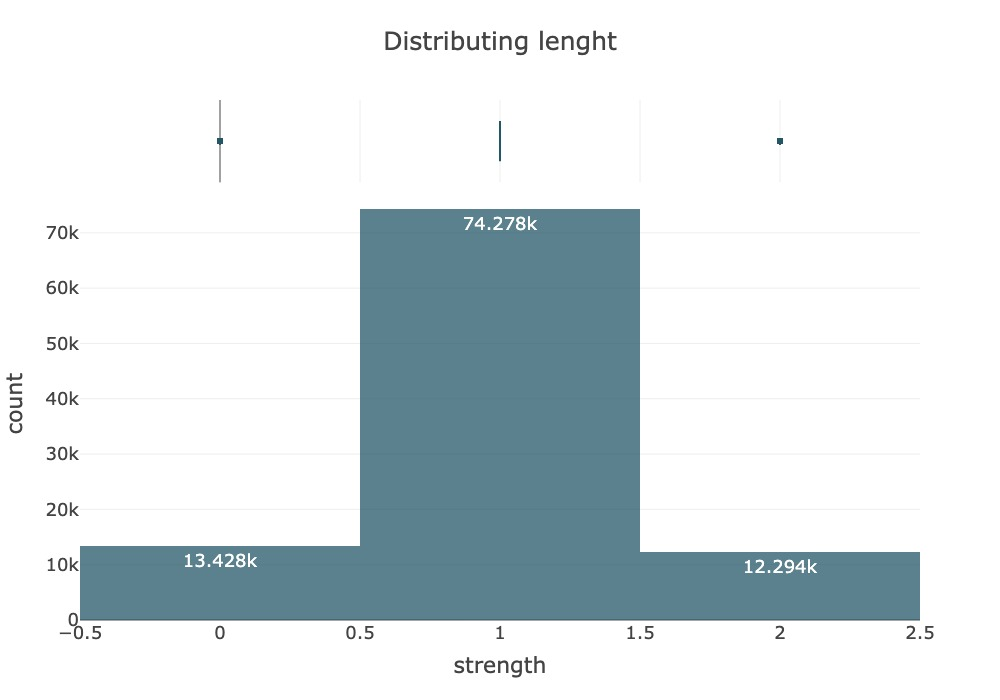

In [9]:
# посмотрим распределение данных
fig = px.histogram(df,
             x='strength',
             barmode='group',
             marginal='box',
             color_discrete_sequence=px.colors.sequential.Aggrnyl,
             width = 1000, 
             height = 700, 
             opacity=0.75,
             title=f'Distributing lenght',
             template='presentation',
             text_auto=True
            )

fig.show('jpeg')

<hr style="border-style: dashed;">

__Вывод:__  
- 0 (слабый) - 13.428 (13.43%)
- 1 (средний) - 74.278 (74.28%)
- 2 (сильный) - 12.294 (12.29%)

Параметр распределен нормально. Как видим наибольшее количество у нас занимает средний уровень, затем идет слабый и с небольшим отставанием по количеству сильный.
Возможно здесь стоит сделать кодирование на флаги?

<hr style="border-style: dashed;">

### digit_len

Числовой признак, который выражает число цифр в пароле.

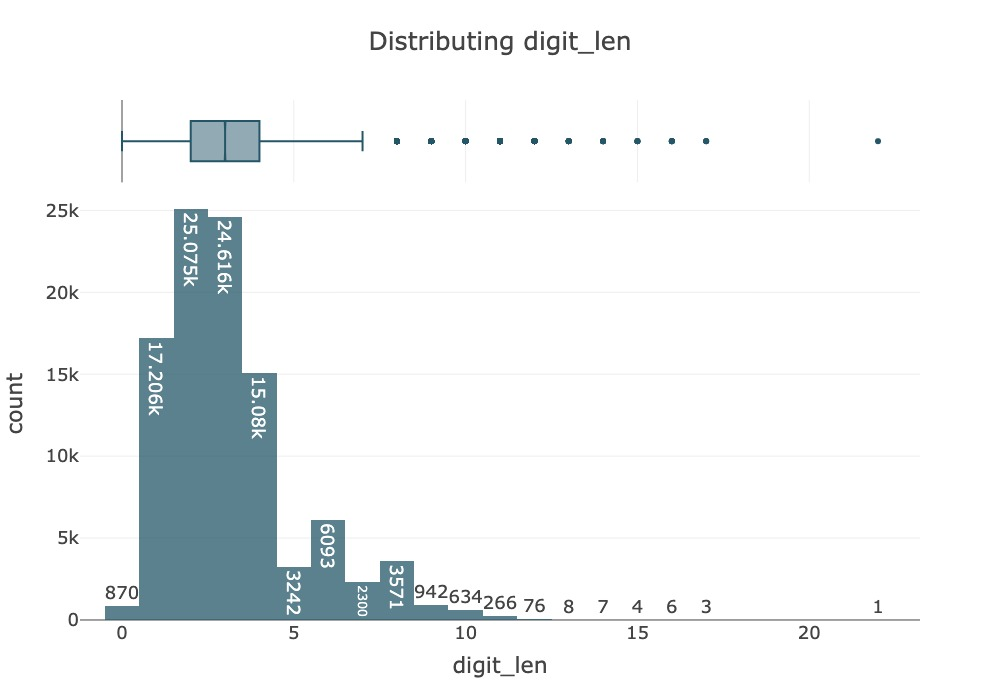

In [10]:
# посмотрим распределение данных
fig = px.histogram(df,
             x='digit_len',
             barmode='group',
             marginal='box',
             color_discrete_sequence=px.colors.sequential.Aggrnyl,
             width = 1000, 
             height = 700, 
             opacity=0.75,
             title=f'Distributing digit_len',
             template='presentation',
             text_auto=True
            )

fig.show('jpeg')

In [11]:
# стат. данные
display(df['digit_len'].describe().round(2))

count    100000.00
mean          3.18
std           2.00
min           0.00
25%           2.00
50%           3.00
75%           4.00
max          22.00
Name: digit_len, dtype: float64

<hr style="border-style: dashed;">

__Вывод:__  
- минимальное значение - 0 цифр (870 паролей), максимальное значение - 22 цифры (1 пароль)
- мода - 2 цифры (25075 паролей)
- есть выбросы только с правой стороны - от 8 цифр до 22 цифр (всего 5518 паролей)
- 50% паролей содержат цифры в количестве от 2 до 4
- правосторонее распределение

Как видим распределение признака не нормальное, есть выбросы. 
Возможно придеться провести шкалирование, зависит от того что у нас в других данных.

<hr style="border-style: dashed;">

### alpha_len

Признак обозначающий количество букв в пароле.

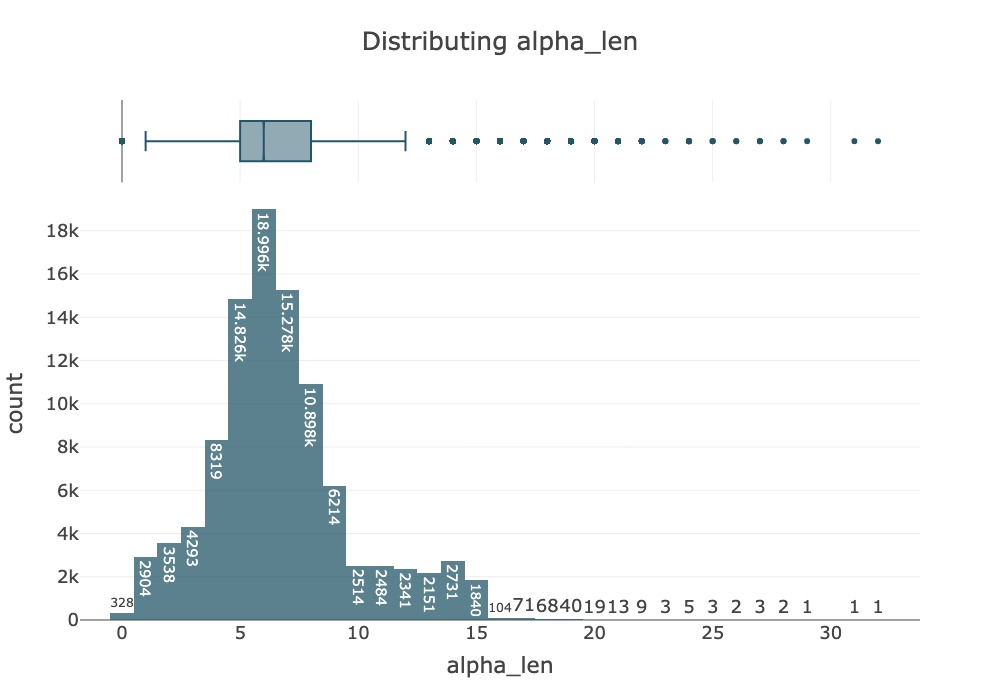

In [13]:
# посмотрим распределение данных
fig = px.histogram(df,
             x='alpha_len',
             barmode='group',
             marginal='box',
             color_discrete_sequence=px.colors.sequential.Aggrnyl,
             width = 1000, 
             height = 700, 
             opacity=0.75,
             title=f'Distributing alpha_len',
             template='presentation',
             text_auto=True
            )

fig.show('jpeg')

In [14]:
# стат. данные
display(df['alpha_len'].describe().round(2))

count    100000.00
mean          6.75
std           3.09
min           0.00
25%           5.00
50%           6.00
75%           8.00
max          32.00
Name: alpha_len, dtype: float64

<hr style="border-style: dashed;">

__Вывод:__  
- минимальное значение - 0 букв (328 паролей), максимальное значение - 32 буквы (1 пароль)
- мода 6 букв (18996 паролей)
- присутствуют выбросы: слева 1 выброс (0 букв - 328 паролей), справа от 13 букв до 32 букв (всего справа 7067 паролей)
- 50% паролей содержат буквы в количестве от 5 до 8 
- правосторонее распределение

Как видим распределение признака ненормальное, есть выбросы. Возможно придеться провести шкалирование, зависит от того что у нас в других данных.

<hr style="border-style: dashed;">

### special_symbol_len

Параметр содержит количество символов, которые не являются буквами или цифрами.

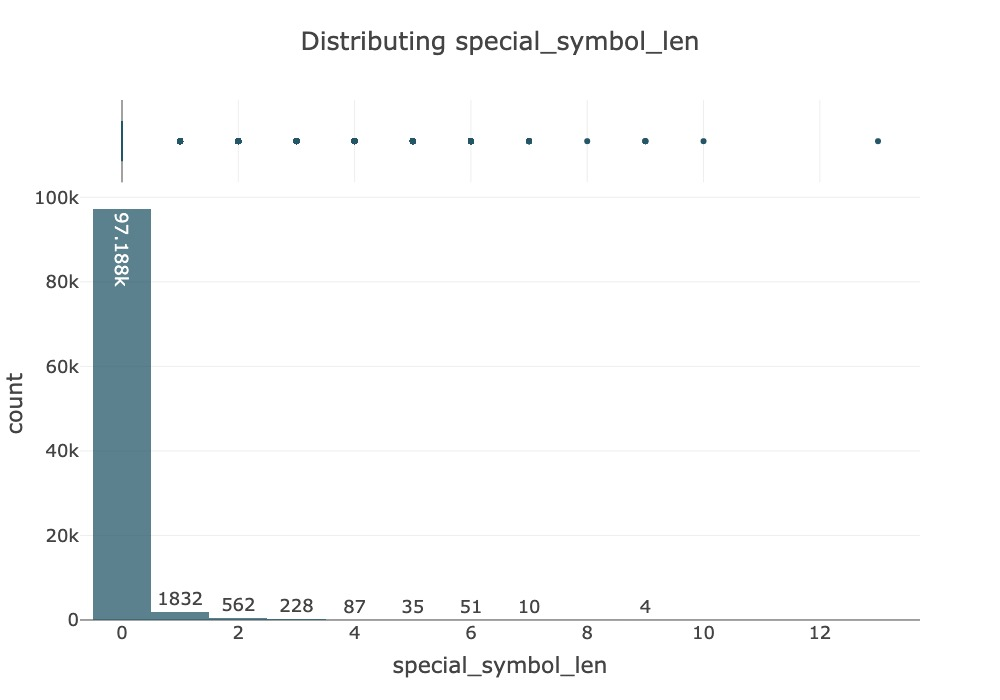

In [16]:
# посмотрим распределение данных
fig = px.histogram(df,
             x='special_symbol_len',
             barmode='group',
             marginal='box',
             color_discrete_sequence=px.colors.sequential.Aggrnyl,
             width = 1000, 
             height = 700, 
             opacity=0.75,
             title=f'Distributing special_symbol_len',
             template='presentation',
             text_auto=True
            )

fig.show('jpeg')

In [17]:
# стат. данные
display(df['special_symbol_len'].describe().round(2))

count    100000.00
mean          0.05
std           0.33
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          13.00
Name: special_symbol_len, dtype: float64

<hr style="border-style: dashed;">

__Вывод:__  
- минимальное значение - 0 символов (97188), максимальное значение 13 символов (1 пароль)
- мода 0 символов (97188)
- присутствуют выбросы справа от 1 символа до 13 символов (всего 2812 паролей)
- более 97% паролей не содержат спец. символы
- правосторнее распределение

Как видим здесь также распределние отличное от нормального, 97% паролей не содержат символы отличные от букв и цифр. Возможно замена на флаги наличия/отсутствия спец символов. 

<hr style="border-style: dashed;">

### upper_letter_len

Параметр содержит количество больших букв в пароле.

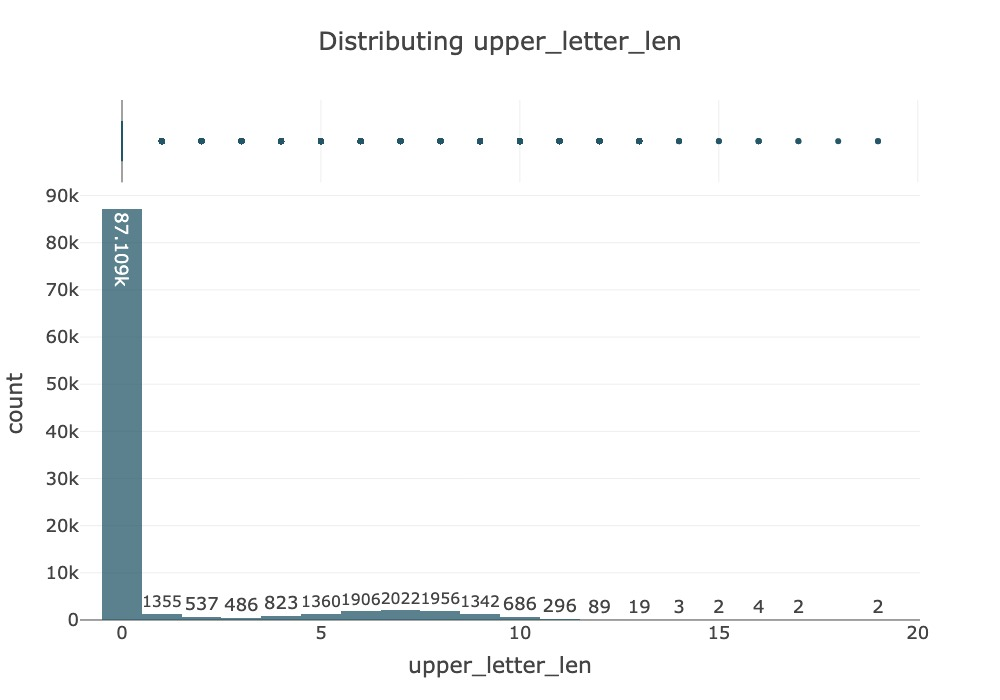

In [18]:
# посмотрим распределение данных
fig = px.histogram(df,
             x='upper_letter_len',
             barmode='group',
             marginal='box',
             color_discrete_sequence=px.colors.sequential.Aggrnyl,
             width = 1000, 
             height = 700, 
             opacity=0.75,
             title=f'Distributing upper_letter_len',
             template='presentation',
             text_auto=True
            )

fig.show('jpeg')

In [19]:
# стат. данные
display(df['upper_letter_len'].describe().round(2))

count    100000.00
mean          0.79
std           2.28
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          19.00
Name: upper_letter_len, dtype: float64

<hr style="border-style: dashed;">

__Вывод:__  
- минимальное значение - 0 больших букв (87109), максимальное значение 19 больших букв (2 пароля)
- мода 0 больших букв (87109)
- присутствуют выбросы справа от 1 большой буквы до 19 больших букв (всего 12891 пароль)
- более 87% паролей не содержат большие буквы
- правосторнее распределение

Как видим здесь также распределние отличное от нормального, 87% паролей не содержат большие буквы. 

<hr style="border-style: dashed;">

### is_dublicate

Параметр содержит общее количество дубликатов в пароле

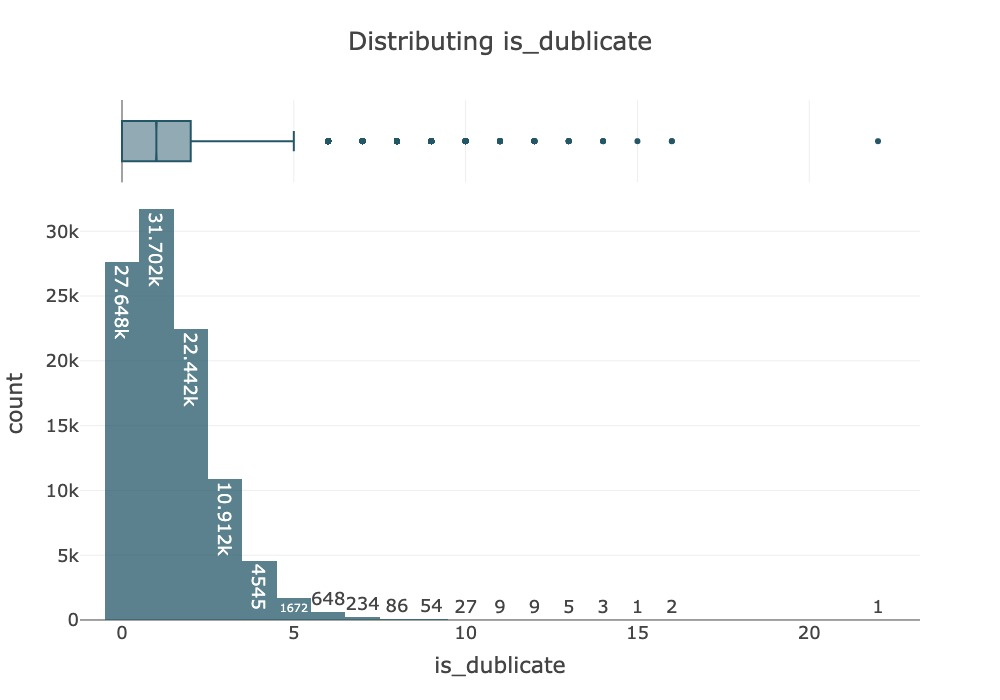

In [20]:
# посмотрим распределение данных
fig = px.histogram(df,
             x='is_dublicate',
             barmode='group',
             marginal='box',
             color_discrete_sequence=px.colors.sequential.Aggrnyl,
             width = 1000, 
             height = 700, 
             opacity=0.75,
             title=f'Distributing is_dublicate',
             template='presentation',
             text_auto=True
            )

fig.show('jpeg')

In [21]:
# стат. данные
display(df['is_dublicate'].describe().round(2))

count    100000.00
mean          1.43
std           1.35
min           0.00
25%           0.00
50%           1.00
75%           2.00
max          22.00
Name: is_dublicate, dtype: float64

<hr style="border-style: dashed;">

__Вывод:__  
- минимальное значение - 0 дубликатов (27648 паролей), максимальное значение 22 дубликата (1 пароль)
- мода 1 дубликат (31702 пароля)
- присутствуют выбросы справа от 6 дубликатов до 22 дубликатов в паролей (всего 1079 паролей)
- 50% паролей содержат от 0 до 2 дубликатов
- правосторнее распределение

Как видим распределние отличное от нормального, большая часть паролей содержит какие либо дубликаты, то есть в повторяются либо буквы, либо цифры, либо спец. символы.

<hr style="border-style: dashed;">

### little_letter_len

Параметр содержит количество строчных букв в слове.

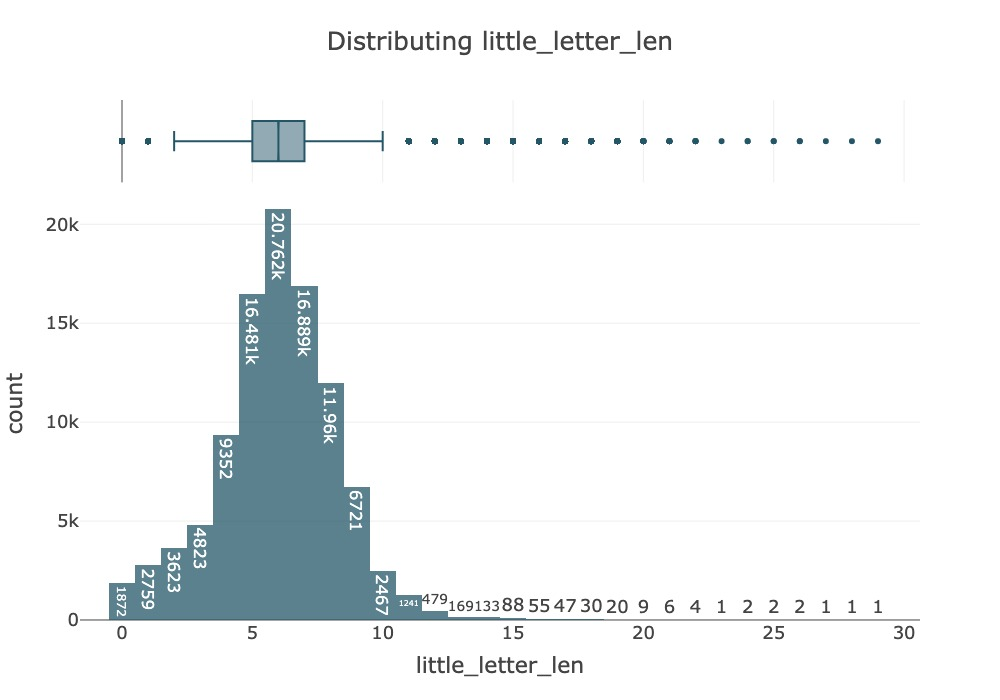

In [22]:
# посмотрим распределение данных
fig = px.histogram(df,
             x='little_letter_len',
             barmode='group',
             marginal='box',
             color_discrete_sequence=px.colors.sequential.Aggrnyl,
             width = 1000, 
             height = 700, 
             opacity=0.75,
             title=f'Distributing little_letter_len',
             template='presentation',
             text_auto=True
            )

fig.show('jpeg')

In [23]:
# стат. данные
display(df['little_letter_len'].describe().round(2))

count    100000.00
mean          5.96
std           2.36
min           0.00
25%           5.00
50%           6.00
75%           7.00
max          29.00
Name: little_letter_len, dtype: float64

<hr style="border-style: dashed;">

__Вывод:__  
- минимальное значение - 0 строчных букв (1872 пароля), максимальное значение 29 строчных букв (1 пароль)
- мода 6 строчных букв (20762 пароля)
- присутствуют выбросы: слева от 0 до 1 (всего 4631 пароля) справа от 11 строчных букв до 29 строчных букв в паролей (всего 2291 пароль)
- 50% паролей содержат от 5 до 7 строчных букв
- правосторнее распределение

Как видим распределние отличное от нормального, содержит выбросы.

<hr style="border-style: dashed;">

### lenght

Параметр содержит длину пароля.

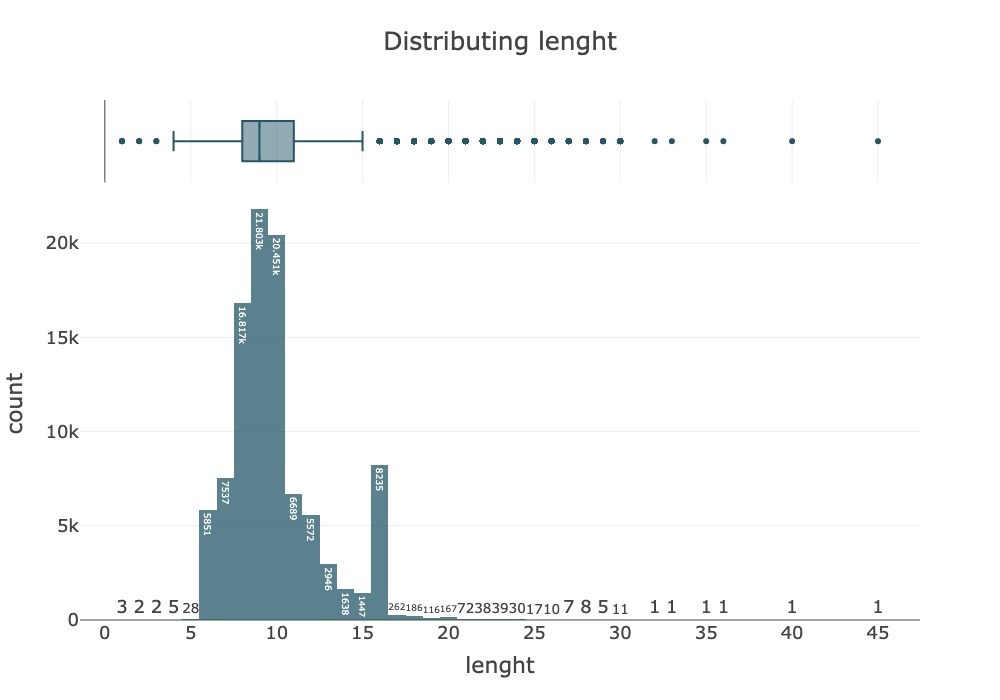

In [24]:
# посмотрим распределение данных
fig = px.histogram(df,
             x='lenght',
             barmode='group',
             marginal='box',
             color_discrete_sequence=px.colors.sequential.Aggrnyl,
             width = 1000, 
             height = 700, 
             opacity=0.75,
             title=f'Distributing lenght',
             template='presentation',
             text_auto=True
            )

fig.show('jpeg')

In [25]:
# стат. данные
display(df['lenght'].describe().round(2))

count    100000.00
mean          9.98
std           2.77
min           1.00
25%           8.00
50%           9.00
75%          11.00
max          45.00
Name: lenght, dtype: float64

<hr style="border-style: dashed;">

__Вывод:__  
- минимальное значение - длина 1 символ (3 пароля), максимальное значение длина 45 символов (1 пароль)
- мода длина 9 символов (21803 пароля)
- присутствуют выбросы: слева от 1 до 3 символов длина (всего 7 паролей) справа от 16 до 45 букв длина (всего 9209 паролей)
- 50% паролей длиной от 8 до 11 символов
- правосторнее распределение

Как видим распределние отличное от нормального, содержит выбросы.

<hr style="border-style: dashed;">

__Итого:__  
После анализа мы можем сказать, что признаки: 'digit_len', 'alpha_len', 'special_symbol_len', 'upper_letter_len', 'is_dublicate', 'little_letter_len', 'lenght', у нас распределенны с отличием от нормального.  
Наш целевой признак - 'strength' распределен нормально.  
Признак special_symbol_len содержит 97% одинаковых значений - возможно, стоит заменить его просто наличием/отсутствием флага наличия спец. символов.

По поводу шкалирования данных в принципе у нас в одном порядке находятся все данные, кроме целевого параметра который категориальный.

***

# <center> EDA
    
Здесь мы посмотрим зависимость и распределение признаков относительно целевого параметра - strength
    
### strength - digit_len

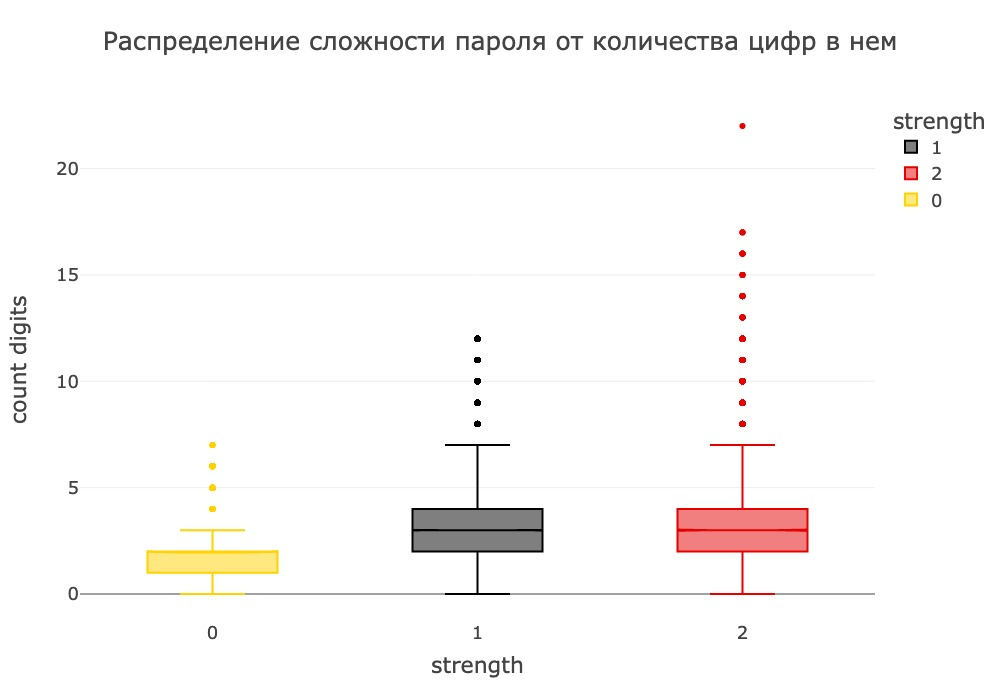

In [26]:
# посмотрим график распределения сложности пароля от количество цифр в нем
# График
fig = px.box(df, 
        y = 'digit_len', 
        x = 'strength', 
        title = 'Распределение сложности пароля от количества цифр в нем',
        color = 'strength',
        color_discrete_sequence = px.colors.sequential.Hot,
        template = 'presentation',
        height = 700, 
        width = 1000,
        notched=True,
        labels={'digit_len':'count digits'}
        )

fig.show('jpeg')

In [27]:
# посмотрим распределение категорий паролей относительно количества цифр
df.groupby('strength')['digit_len'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
strength,,,,,,,,
0,13428.0,1.76,0.92,0.0,1.0,2.0,2.0,7.0
1,74278.0,3.45,2.04,0.0,2.0,3.0,4.0,12.0
2,12294.0,3.10,1.98,0.0,2.0,3.0,4.0,22.0


<hr style="border-style: dashed;">

__Вывод:__  

Как мы видим в средних и сильных паролях одинаковое распределение количества цифр, кроме выбросов. В слабых паролях цифр значителтно меньше. Также мы видим возрастание количества выбросов от слабых паролей к сильным.  
Полагаю основное различие м/д средними и сильными праолями в длине паролей.  
Также стоит отметить, что mean у средних паролей чуть выше, чем у сильных (мы помним, что средние пароли занимают 74% данных).

Отсюда мы можем сделать вывод, что наличие и количество цифр, хоть и играет роль в сложности пароля, но после средних паролей, эта особенность выходит на своеобразное плато и его знаичмость уменьшается.

<hr style="border-style: dashed;">

### strength - alpha_len

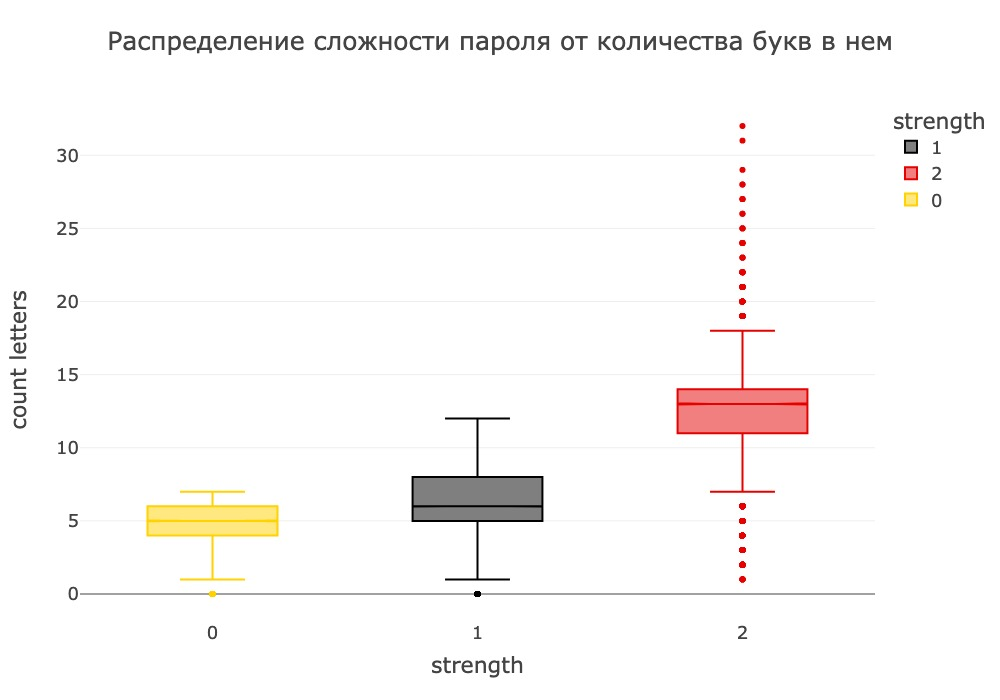

In [28]:
# распределения сложности пароля в зависимости от количества букв
# График
fig = px.box(df, 
        y = 'alpha_len', 
        x = 'strength', 
        title = 'Распределение сложности пароля от количества букв в нем',
        color = 'strength',
        color_discrete_sequence = px.colors.sequential.Hot,
        template = 'presentation',
        height = 700, 
        width = 1000,
        notched=True,
        labels={'alpha_len':'count letters'}
        )

fig.show('jpeg')

In [29]:
# посмотрим статистику
df.groupby('strength')['alpha_len'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
strength,,,,,,,,
0,13428.0,4.77,1.16,0.0,4.0,5.0,6.0,7.0
1,74278.0,6.14,2.21,0.0,5.0,6.0,8.0,12.0
2,12294.0,12.57,2.52,1.0,11.0,13.0,14.0,32.0


<hr style="border-style: dashed;">

__Вывод:__  
Здесь мы видим, постепенный рост количества букв, от слабых паролей до сильных. Также хочу отметить, что у всех паролей есть выбросы в количестве букв, в особенности у сильных паролей, 6 выбросов слева и 13 выбросов справа. У слабых и средних паролей выбросы тоже есть, но они расположенны слева (внизу в данном случае), по одной штуке - показывая отсутсвие в букв в данных паролях.   
Также хочу отметить разницы м/д статистическими данными уровней паролей: среднее и медиана у сильных паролей в два раза больше чем у средних.

<hr style="border-style: dashed;">

### strength - special_symbol_len

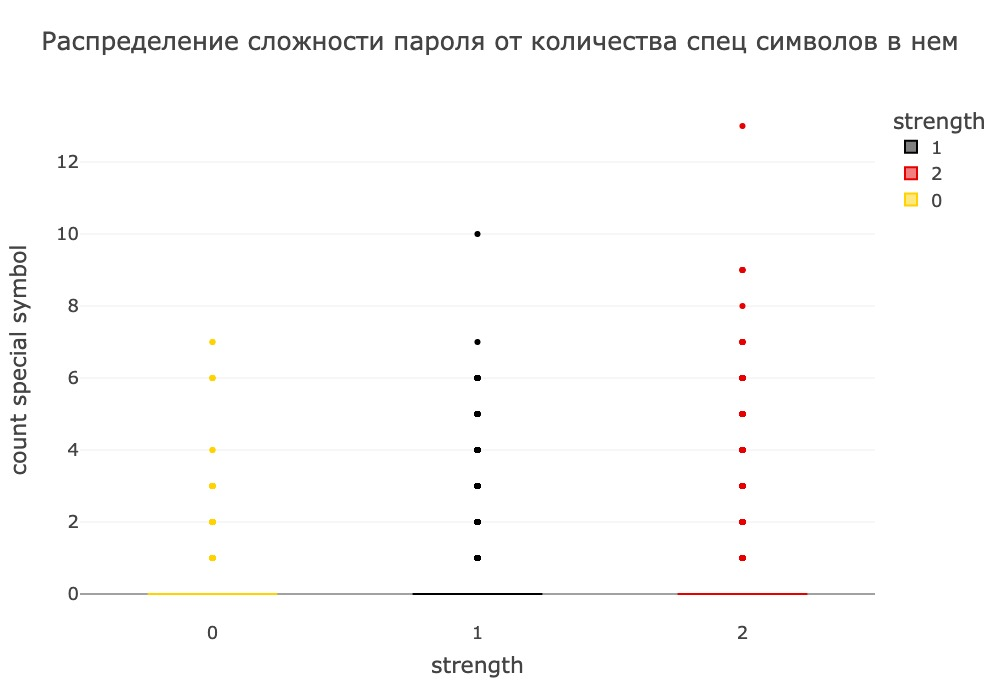

In [30]:
# распределения сложности пароля в зависимости от количества специальных симоволов
# График
fig = px.box(df, 
        y = 'special_symbol_len', 
        x = 'strength', 
        title = 'Распределение сложности пароля от количества спец символов в нем',
        color = 'strength',
        color_discrete_sequence = px.colors.sequential.Hot,
        template = 'presentation',
        height = 700, 
        width = 1000,
        notched=True,
        labels={'special_symbol_len':'count special symbol'}
        )

fig.show('jpeg')

In [31]:
# посмотрим статистику
df.groupby('strength')['special_symbol_len'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
strength,,,,,,,,
0,13428.0,0.02,0.22,0.0,0.0,0.0,0.0,7.0
1,74278.0,0.02,0.21,0.0,0.0,0.0,0.0,10.0
2,12294.0,0.23,0.73,0.0,0.0,0.0,0.0,13.0


<hr style="border-style: dashed;">

__Вывод:__  
Как мы и говорили раннее, бесполезный для нас параметр, так как в 97% случаев не используються спец символы, а оставшиеся 3% это выбросы, количество которых возрастает по мере увеличения сложности пароля. Удалим данный столбец. 

<hr style="border-style: dashed;">

### strength - upper_letter_len

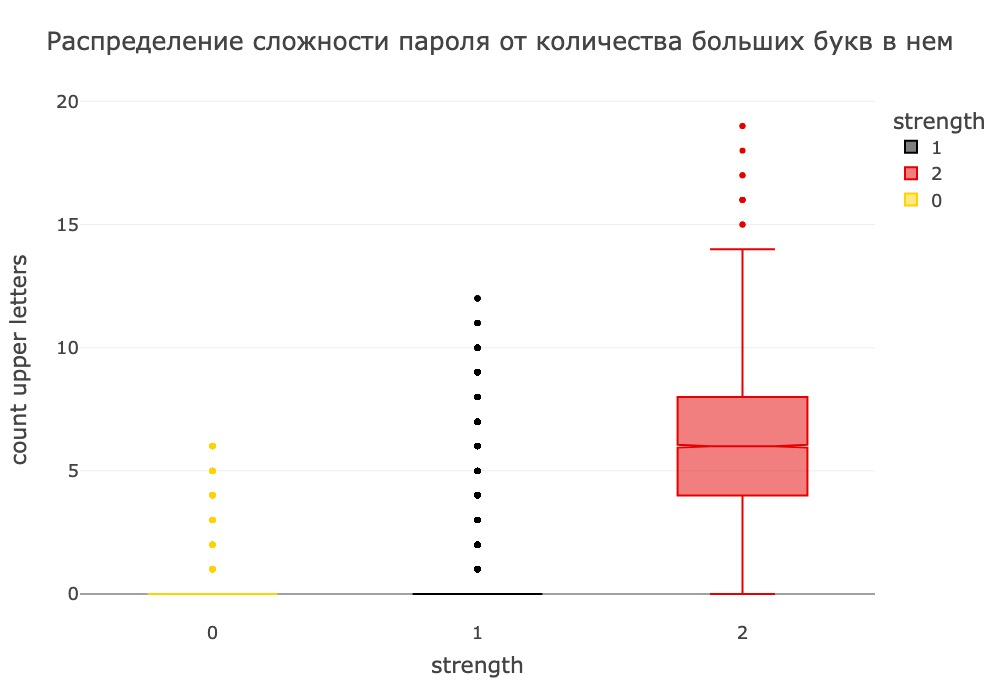

In [32]:
# распределения сложности пароля в зависимости от количества больших букв
# График
fig = px.box(df, 
        y = 'upper_letter_len', 
        x = 'strength', 
        title = 'Распределение сложности пароля от количества больших букв в нем',
        color = 'strength',
        color_discrete_sequence = px.colors.sequential.Hot,
        template = 'presentation',
        height = 700, 
        width = 1000,
        notched=True,
        labels={'upper_letter_len':'count upper letters'}
        )

fig.show('jpeg')

In [33]:
# посмотрим статистику
df.groupby('strength')['upper_letter_len'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
strength,,,,,,,,
0,13428.0,0.08,0.61,0.0,0.0,0.0,0.0,6.0
1,74278.0,0.08,0.71,0.0,0.0,0.0,0.0,12.0
2,12294.0,5.84,3.10,0.0,4.0,6.0,8.0,19.0


<hr style="border-style: dashed;">

__Вывод:__  
На графике видно, что данный параметр важен для сильных паролей и в 50% случаев они содержат от 4 до 8 больших букв. В средних и слабых паролях большие буквы присутствуют только как выбросы. Выбросы присутствуют и в сильных паролях 15-19 больших букв.

<hr style="border-style: dashed;">

### strength - is_dublicate

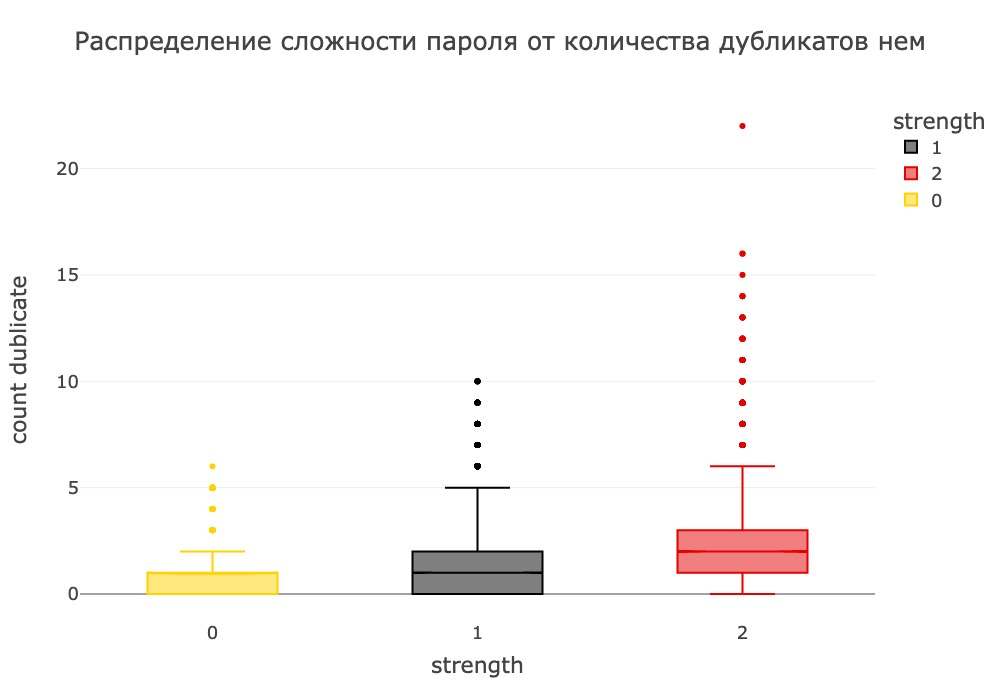

In [34]:
# распределения сложности пароля в зависимости от количества дубликатов
# График
fig = px.box(df, 
        y = 'is_dublicate', 
        x = 'strength', 
        title = 'Распределение сложности пароля от количества дубликатов нем',
        color = 'strength',
        color_discrete_sequence = px.colors.sequential.Hot,
        template = 'presentation',
        height = 700, 
        width = 1000,
        notched=True,
        labels={'is_dublicate':'count dublicate'}
        )

fig.show('jpeg')

In [35]:
# посмотрим статистику
df.groupby('strength')['is_dublicate'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
strength,,,,,,,,
0,13428.0,0.77,0.92,0.0,0.0,1.0,1.0,6.0
1,74278.0,1.42,1.29,0.0,0.0,1.0,2.0,10.0
2,12294.0,2.20,1.66,0.0,1.0,2.0,3.0,22.0


<hr style="border-style: dashed;">

__Вывод:__   
Мы видим рост количества дубликатов от слабых к сильным паролям. Если в слабых паролях дубликаты в основном 0-1 (медианна 1), то в средних в основном 0-2 (медиана 1), а в сильных уже 1-3 (медиана 2). Также мы можем видеть рост выбросов от слабых паролей к сильным.
Также хочу отметить, что mean от слабого к сильному, с каждой категорией растет в 2 раза.  
Мы можем сказать, что данный параметр является важным для сложности пароля.

<hr style="border-style: dashed;">

### strength - little_letter_len

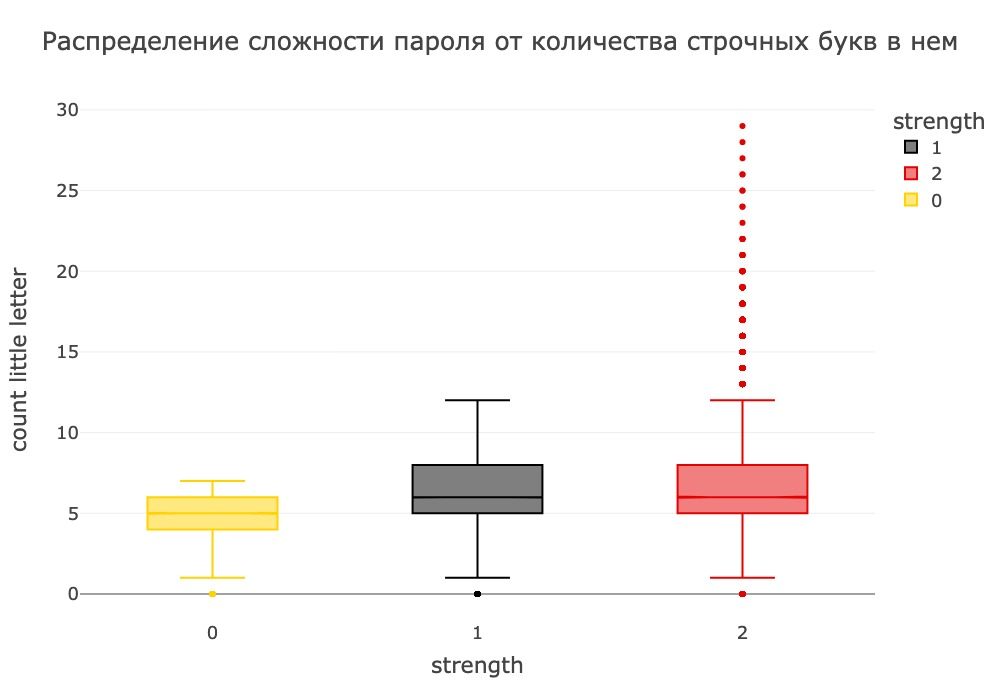

In [36]:
# распределения сложности пароля в зависимости от количества строчных букв в нем
# График
fig = px.box(df, 
        y = 'little_letter_len', 
        x = 'strength', 
        title = 'Распределение сложности пароля от количества строчных букв в нем',
        color = 'strength',
        color_discrete_sequence = px.colors.sequential.Hot,
        template = 'presentation',
        height = 700, 
        width = 1000,
        notched=True,
        labels={'little_letter_len':'count little letter'}
        )

fig.show('jpeg')

In [37]:
# посмотрим статистику
df.groupby('strength')['little_letter_len'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
strength,,,,,,,,
0,13428.0,4.69,1.31,0.0,4.0,5.0,6.0,7.0
1,74278.0,6.06,2.31,0.0,5.0,6.0,8.0,12.0
2,12294.0,6.73,2.91,0.0,5.0,6.0,8.0,29.0


<hr style="border-style: dashed;">

__Вывод:__   
На грфике мы видим, что соотношение количества строчных букв для средних и сильных паролей одинаковое. Также хочу отметить, наличие выбросов у всех трех категорий слева (снизу), которые заключаются в отсутствие строчных букв в некоторых паролях данных категорий.   
Здесь мы также мы можем сделать вывод, что количество строчных букв играет роль, но после средних паролей значение падает, так как в сильных паролях оно остается на том же увовне.

Также хочу отметить наличие большого числа выбросов в сильных паролях (13-29 букв).

<hr style="border-style: dashed;">

### strength - lenght

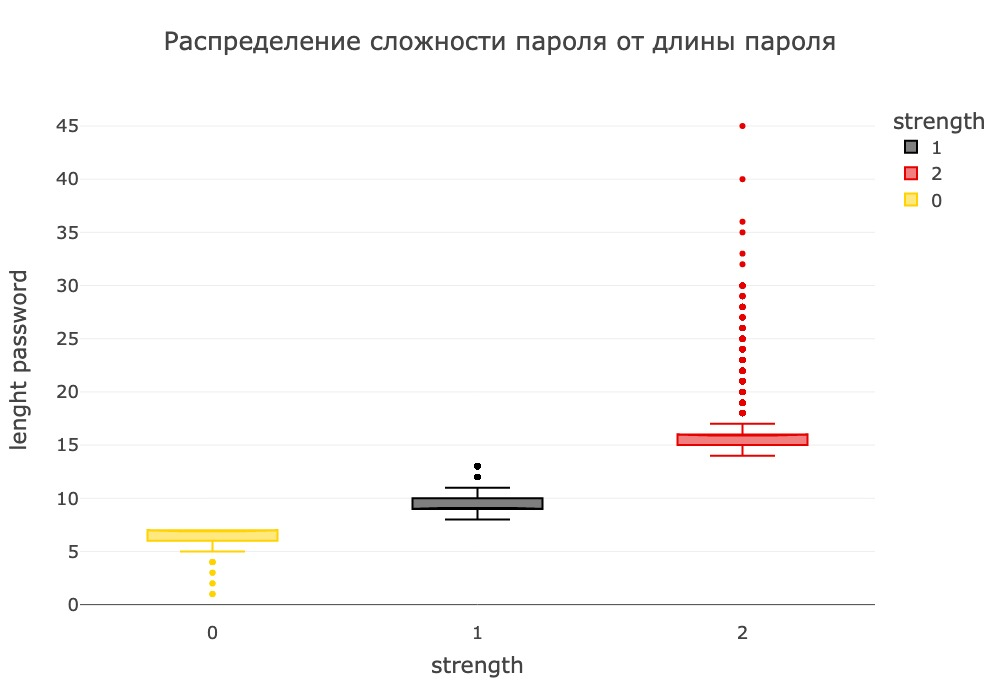

In [38]:
# распределения сложности пароля в зависимости от длины пароля
# График
fig = px.box(df, 
        y = 'lenght', 
        x = 'strength', 
        title = 'Распределение сложности пароля от длины пароля',
        color = 'strength',
        color_discrete_sequence = px.colors.sequential.Hot,
        template = 'presentation',
        height = 700, 
        width = 1000,
        notched=True,
        labels={'lenght':'lenght password'}
        )

fig.show('jpeg')

In [39]:
# посмотрим статистику
df.groupby('strength')['lenght'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
strength,,,,,,,,
0,13428.0,6.56,0.51,1.0,6.0,7.0,7.0,7.0
1,74278.0,9.61,1.34,8.0,9.0,9.0,10.0,13.0
2,12294.0,15.90,1.55,14.0,15.0,16.0,16.0,45.0


<hr style="border-style: dashed;">

__Вывод:__   
    Здесь мы видим, четкое разделение по категориям без какого либо пересения м/д ними. Слабые пароли от 5 до 7, с основынм телом 6-7, медианной 7 и выбросами слева (внизу) в виде длины пароля 1-4 символа, средние пароли от 8 до 13, с основным телом 9-10, медианной 9   и выбросами справа (верх) 12-13 и сильные пароли от 14 до 17, с основным телом 15-16, медианной 16 и выбросами справа (верх) 18-45.  Хочу отметить, что у слабых паролей медиана смешенна к нижней границы основного тела, а в средней и сильной категорий к верхней границы основного тела.
    
На основание графика можем сделать вывод, что длина является одним из важнейщих парамтров силы пароля.

<hr style="border-style: dashed;">

__Итого:__  
Исходя из нашего анализа, мы можем сказать, на криптостойкость пароля сильное влияние оказывают следующие параметры: длина пароля ('lenght'), количество букв в пароле ('alpha_len'), количество дубликатов в пароле ('is_dublicate'). Чуть менне сильное: количество строчных букв в пароли ('little_letter_len'), количество цифр в пароли ('digit_len'). Особняком стоит количество больших букв в пароле ('upper_letter_len'), как правило это указывает на сильный пароль, но есть исключение в виде выбросов в слабых и средних паролях. Также мы удаляем парамет количество спец символов ('special_symbol_len'), так как он оказался для нас бесполезен и будет портить нам обучения - из-за того, что 97% паролей не содержат эти символы.

***

In [40]:
# убираем столбец 'special_symbol_len'
df = df.drop(['special_symbol_len'], axis=1)
display(df.shape)

(100000, 8)

Так как при анализе мы видели, что данные в столбцах у нас распределенны отлично от нормального, то воспользуемся методом визуализации kdeplot() — распределения наблюдений в наборе данных, чтобы подвердить это. Он представляет собой непрерывную линию плотности вероятности. 

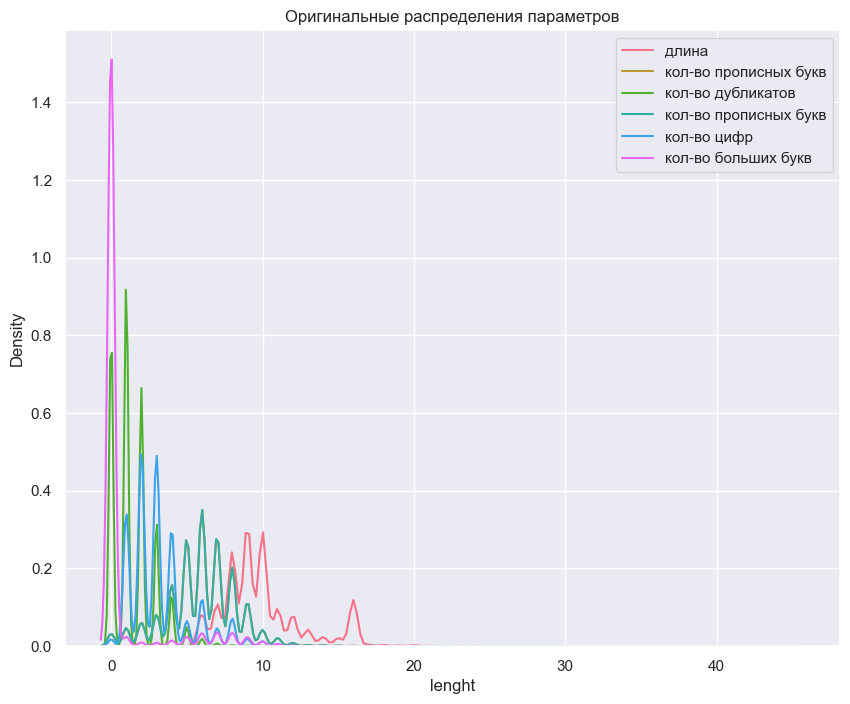

In [41]:
# зададим параметры графика, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Оригинальные распределения параметров')

# kdeplot()(KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(df['lenght'], ax=ax1, label ='длина')
sns.kdeplot(df['little_letter_len'], ax=ax1, label ='кол-во прописных букв')
sns.kdeplot(df['is_dublicate'], ax=ax1, label ='кол-во дубликатов')
sns.kdeplot(df['little_letter_len'], ax=ax1, label ='кол-во прописных букв')
sns.kdeplot(df['digit_len'], ax=ax1, label ='кол-во цифр')
sns.kdeplot(df['upper_letter_len'], ax=ax1, label ='кол-во больших букв')
plt.legend();

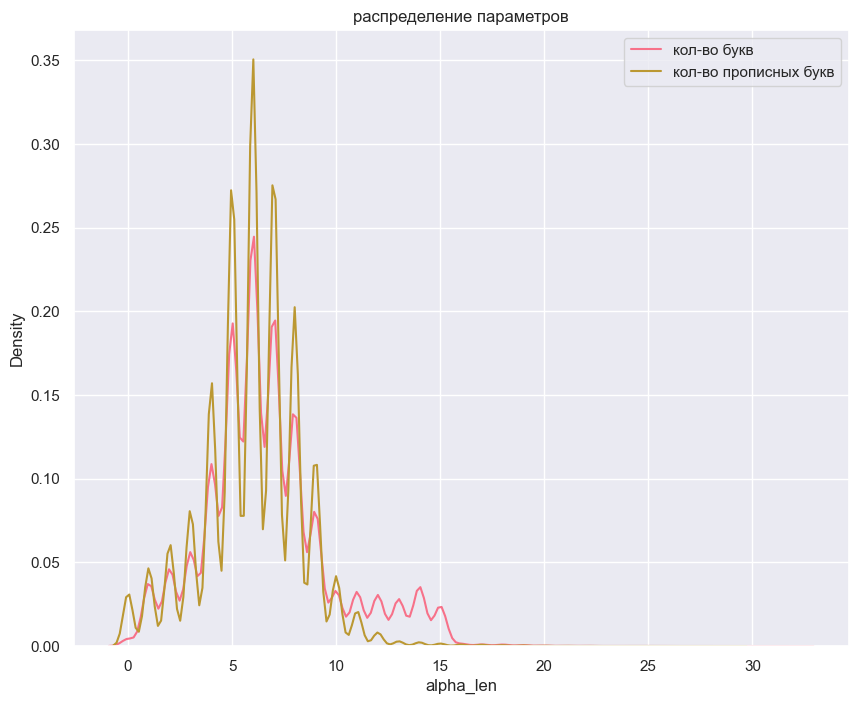

In [42]:
# зададим параметры графика, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('распределение параметров')
sns.kdeplot(df['alpha_len'], ax=ax1, label ='кол-во букв')
sns.kdeplot(df['little_letter_len'], ax=ax1, label ='кол-во прописных букв')
plt.legend();

<hr style="border-style: dashed;">

__Вывод:__  
Как мы помним при анализе мы выявили, что у наших данных в основном правосторонее распределение, на графике kde это прекрасно видно. Также хочу отметить, распределени кол-во букв и кол-во прописных букв, которые повторяют друг друга.  
На основе графиков и информаций о распределение признаков, а также о наличие выбросов в признаков - мы нормализуем данные с помошью метода RobustScaler (здесь в вычислении использует перцентили, и поэтому не зависит даже от большого количества выбросов).

<hr style="border-style: dashed;">


In [43]:
# Зафиксируем описательные статистики до преобразований.
df.describe()

,strength,digit_len,alpha_len,upper_letter_len,is_dublicate,little_letter_len,lenght
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000
mean,0.988660,3.18047,6.749010,0.789520,1.43215,5.95949,9.975540
std,0.507044,1.99945,3.090743,2.276895,1.34724,2.35646,2.766384
min,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,1.000000
25%,1.000000,2.00000,5.000000,0.000000,0.00000,5.00000,8.000000
50%,1.000000,3.00000,6.000000,0.000000,1.00000,6.00000,9.000000
75%,1.000000,4.00000,8.000000,0.000000,2.00000,7.00000,11.000000
max,2.000000,22.00000,32.000000,19.000000,22.00000,29.00000,45.000000


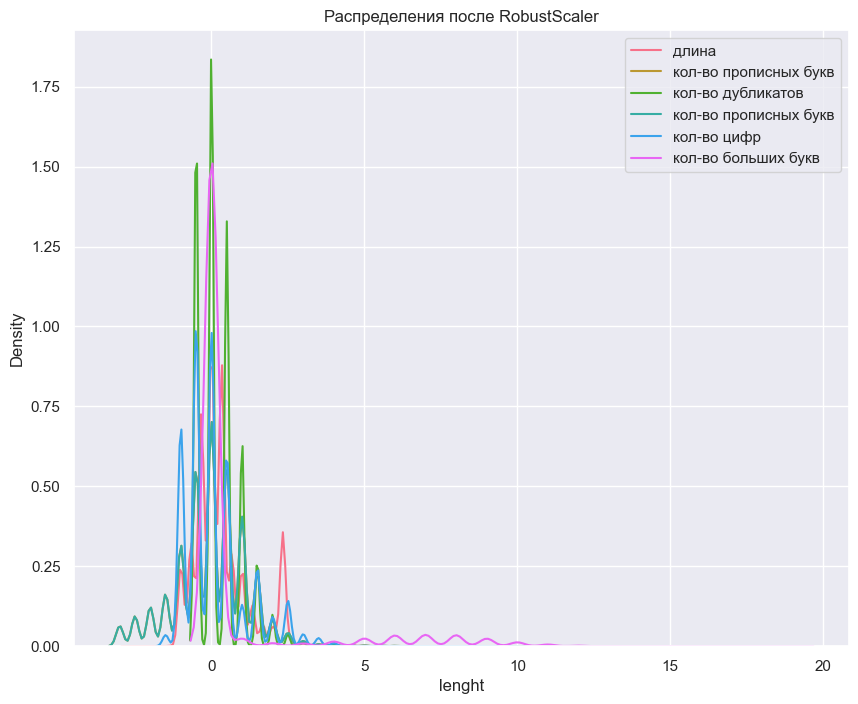

In [44]:
# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = ['digit_len', 'alpha_len', 'upper_letter_len',
       'is_dublicate', 'little_letter_len', 'lenght']
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
df_r = r_scaler.fit_transform(df[['digit_len', 'alpha_len',
                                  'upper_letter_len', 'is_dublicate', 
                                  'little_letter_len', 'lenght']])

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после RobustScaler')

sns.kdeplot(df_r['lenght'], ax=ax1, label ='длина')
sns.kdeplot(df_r['little_letter_len'], ax=ax1, label ='кол-во прописных букв')
sns.kdeplot(df_r['is_dublicate'], ax=ax1, label ='кол-во дубликатов')
sns.kdeplot(df_r['little_letter_len'], ax=ax1, label ='кол-во прописных букв')
sns.kdeplot(df_r['digit_len'], ax=ax1, label ='кол-во цифр')
sns.kdeplot(df_r['upper_letter_len'], ax=ax1, label ='кол-во больших букв')
plt.legend();

In [45]:
# добавим целовой параметр
df_r['strength'] = df['strength']
# вернем порядок столбцов как в оригинале для простоты восприятия
df_r = df_r[['strength', 'digit_len', 'alpha_len', 'upper_letter_len', 
      'is_dublicate', 'little_letter_len', 'lenght']]
# Описательные статистики после нормализации:
df_r.describe()

,strength,digit_len,alpha_len,upper_letter_len,is_dublicate,little_letter_len,lenght
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.988660,0.090235,0.249670,0.789520,0.216075,-0.020255,0.325180
std,0.507044,0.999725,1.030248,2.276895,0.673620,1.178230,0.922128
min,0.000000,-1.500000,-2.000000,0.000000,-0.500000,-3.000000,-2.666667
25%,1.000000,-0.500000,-0.333333,0.000000,-0.500000,-0.500000,-0.333333
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.500000,0.666667,0.000000,0.500000,0.500000,0.666667
max,2.000000,9.500000,8.666667,19.000000,10.500000,11.500000,12.000000


### Проведём корреляционный анализ датасетов и используем для этого тепловую карту корреляций признаков.

Оригинальный датасет мы посмотрим с помощью коэффициент корреляции Спирмена, так как там у нас параметры распределенны отлично от нормального. А на нормализованном датасете мы посмотрим корреляцию с помощью метода Пирсона.

In [46]:
# посмотрим таблицу корреляций с помощью метода Спирмена
original_corr = df.corr(method = 'spearman', numeric_only=True).round(2)
original_corr

,strength,digit_len,alpha_len,upper_letter_len,is_dublicate,little_letter_len,lenght
strength,1.00,0.22,0.56,0.66,0.27,0.23,0.78
digit_len,0.22,1.00,-0.48,-0.02,0.24,-0.52,0.24
alpha_len,0.56,-0.48,1.00,0.48,0.09,0.80,0.66
upper_letter_len,0.66,-0.02,0.48,1.00,0.16,-0.05,0.51
is_dublicate,0.27,0.24,0.09,0.16,1.00,0.02,0.36
little_letter_len,0.23,-0.52,0.80,-0.05,0.02,1.00,0.42
lenght,0.78,0.24,0.66,0.51,0.36,0.42,1.00


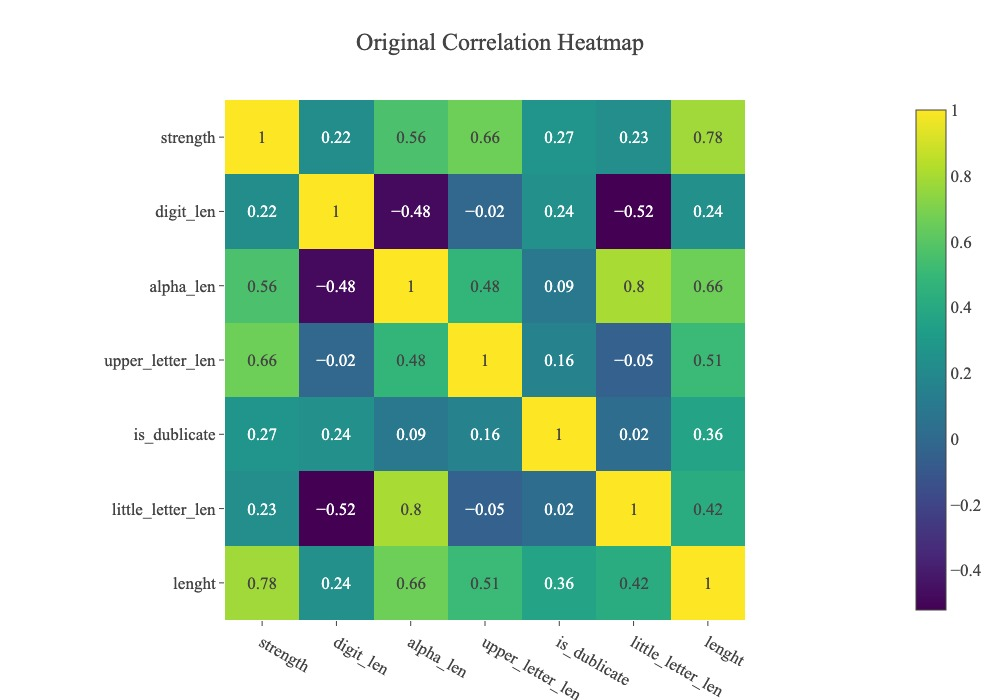

In [47]:
# визуально посмотрим на корреляцию Спирмена
fig = px.imshow(original_corr, 
          text_auto=True,
          title='Original Correlation Heatmap',
          template='presentation',
          width=1000,
          height=700
         )

# Настройка шрифта и наклона категорий оси х
fig.update_layout(font = dict(size=17, 
                              family="TimesNewRoman"
                             )
                 )

fig.show('jpeg');

<hr style="border-style: dashed;">

Положительная сильная связь м/д __strength__ и:
- длина пароля (lenght)

Положительная средняя связь м/д __strength__ и:
- количество букв (alpha_len)
- количество больших букв (upper_letter_len)

Отсутвет связь либо очень слабая положительная связь м/д __strength__ и:
- количество цифр (digit_len)
- количество дубликатов (is_dublicate)
- количество строчных букв (little_letter_len)

Из любопытного:
1. Среднняя отрицательная связь м/д:
- количеством цифр (digit_len) и количеством букв (alpha_len)
- количеством цифр (digit_len) и количеством строчных букв (little_letter_len)
2. Положительная сильная связь м/д:
- количеством букв (alpha_len) и количеством строчных букв (little_letter_len)
3. Отсутствует связь м/д:
- количеством цифр (digit_len) и количеством больших букв (upper_letter_len)
- количеством букв (alpha_len) и количеством дубликатов (is_dublicate)
- количеством больших букв (upper_letter_len) и количеством строчных букв (little_letter_len)
- количеством дубликатов (is_dublicate) и количеством строчных букв (little_letter_len)

Хочу также отметить, что только у 2-х параметров присутствует связь со всеми остальными (в некоторых случаях весьма слабая) - это у целевого параметра strength, и длины пароля (lenght).

Также мы видем и отметили связь м/д предикторами, что скорее всего указывает на нелинейную зависимость, т.е при выборе модели нам придется использовать более сложные модели регрессии, чем линейная.

<hr style="border-style: dashed;">


In [48]:
corr_r = df_r.corr(numeric_only=True).round(2)
corr_r

,strength,digit_len,alpha_len,upper_letter_len,is_dublicate,little_letter_len,lenght
strength,1.00,0.18,0.63,0.62,0.27,0.22,0.85
digit_len,0.18,1.00,-0.50,-0.08,0.31,-0.58,0.17
alpha_len,0.63,-0.50,1.00,0.65,0.12,0.68,0.76
upper_letter_len,0.62,-0.08,0.65,1.00,0.11,-0.11,0.67
is_dublicate,0.27,0.31,0.12,0.11,1.00,0.05,0.38
little_letter_len,0.22,-0.58,0.68,-0.11,0.05,1.00,0.36
lenght,0.85,0.17,0.76,0.67,0.38,0.36,1.00


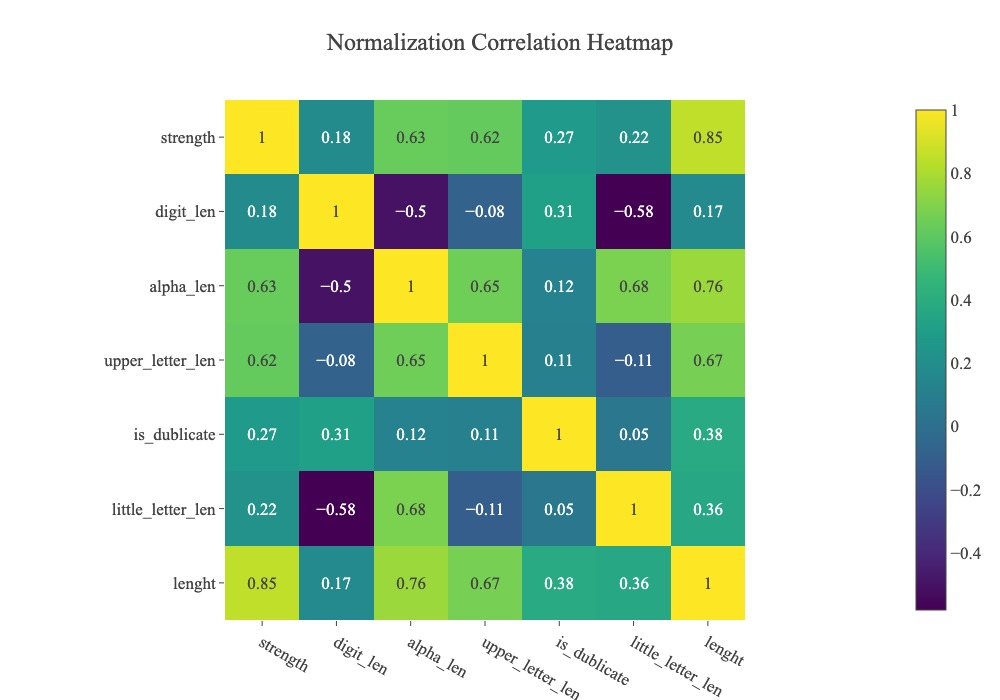

In [49]:
# визуально посмотрим на корреляцию Пирсона
fig = px.imshow(corr_r, 
          text_auto=True,
          title='Normalization Correlation Heatmap',
          template='presentation',
          width=1000,
          height=700
         )

# Настройка шрифта и наклона категорий оси х
fig.update_layout(font = dict(size=17, 
                              family="TimesNewRoman"
                             )
                 )

fig.show('jpeg');

<hr style="border-style: dashed;">

Положительная сильная связь м/д __strength__ и:
- длина пароля (lenght)

Положительная средняя связь м/д __strength__ и:
- количество букв (alpha_len)
- количество больших букв (upper_letter_len)

Отсутвет связь либо очень слабая положительная связь м/д __strength__ и:
- количество цифр (digit_len)
- количество дубликатов (is_dublicate)
- количество строчных букв (little_letter_len)

Из любопытного:
1. Среднняя отрицательная связь м/д:
- количеством цифр (digit_len) и количеством букв (alpha_len)
- количеством цифр (digit_len) и количеством строчных букв (little_letter_len)
2. Положительная сильная связь м/д:
- количеством букв (alpha_len) и длиной пароля (lenght)
3. Отсутствует связь м/д:
- количеством цифр (digit_len) и количеством больших букв (upper_letter_len)
- количеством букв (alpha_len) и количеством дубликатов (is_dublicate)
- количеством больших букв (upper_letter_len) и количеством строчных букв (little_letter_len)
- количеством дубликатов (is_dublicate) и количеством строчных букв (little_letter_len)

В принципе у нас ничего не изменилось практически после нормализаций, лишь сместились акценты в положительная сильная связь м/д: с количеством букв (alpha_len) и количеством строчных букв (little_letter_len) на количеством букв (alpha_len) и длиной пароля (lenght).


Также мы видем и отметили связь м/д предикторами, что скорее всего указывает на нелинейную зависимость, т.е при выборе модели нам придется использовать более сложные модели регрессии, чем линейная.

<hr style="border-style: dashed;">

In [50]:
# Подготовим данные, разбив их по группам для, того чтобы при построение модели
# посмотреть какие ланные лучше использовать
column_names = df.columns.values.tolist()
Predictors_all = df[column_names].drop(columns=['strength','password'])
Predictors_PC = df[['alpha_len', 'upper_letter_len', 'lenght']]
Predictors_0C = df[['digit_len', 'is_dublicate', 'little_letter_len']]
Target = df['strength']

###  Выполним анализ PCA для матрицы корреляций

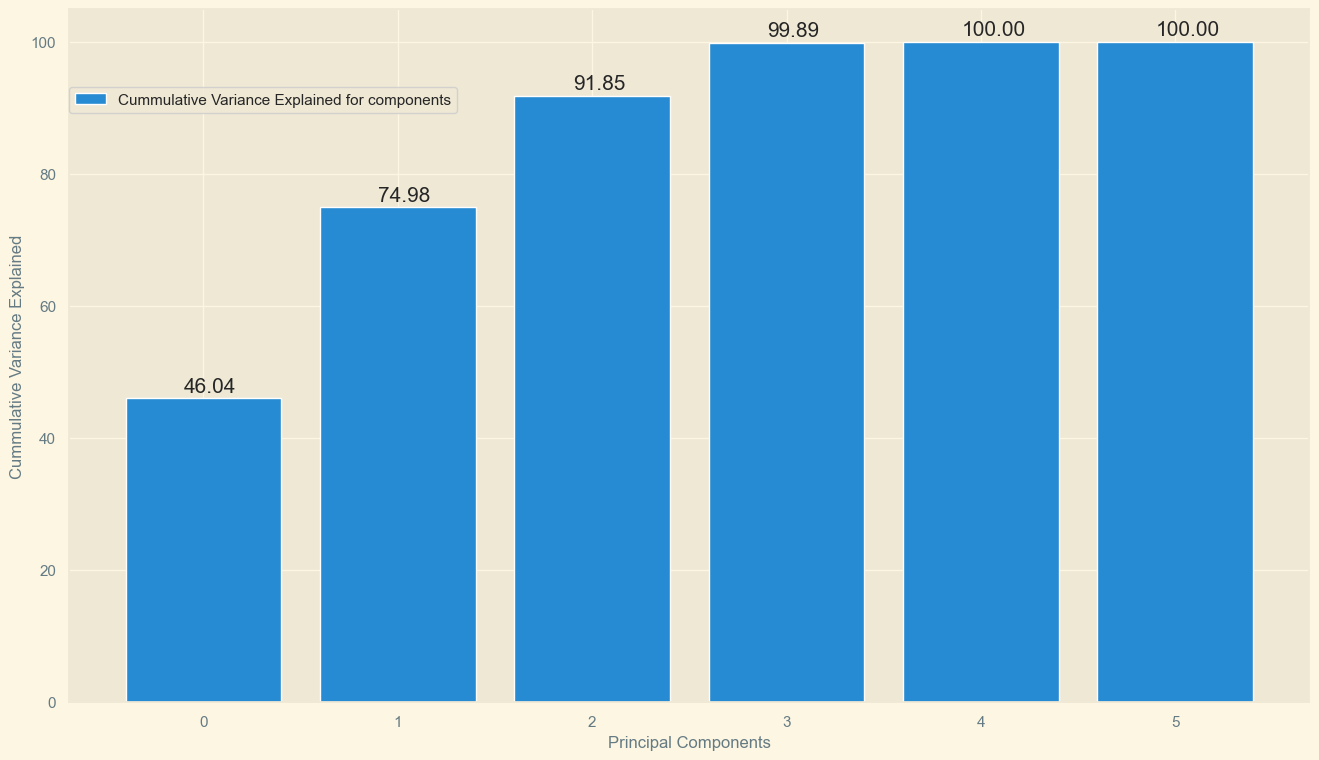

In [51]:
# Посмотрим на % соотношение участия каждого параметра во вклад общей дисперсий 
# Вычисляем корр. матрицу для данных без strength, password 
corr_mat = Predictors_all.corr()
# вычислим значения и вектора корр. матрицы
eig_vals, eig_vectors = np.linalg.eig(corr_mat)
# вычислим общую дисперсию элементов
total_sum = sum(eig_vals)
# вычислим дисперсию для каждого эдемента в %
var_exp = [(i/total_sum)*100 for i in eig_vals]
# вычислим элементы, для понимания того какие из них будем сохранять для модели 
cum_var_exp = np.cumsum(var_exp)

# График для визуального отображения компонентов, это поможет нам принять решение о 
# том, сколько главных компонентов включить в анализ 
with plt.style.context('Solarize_Light2'): # стиль графика
    plt.figure(figsize=(16,9)) # размер графика
    plt.bar(range(6), # кол-во значений по x
            cum_var_exp, # отсюда берем значений дисперсий
            # подпись легенды
            label='Cummulative Variance Explained for components')
    plt.xlabel('Principal Components') # подпись оси x
    plt.ylabel('Cummulative Variance Explained') # подпись оси y
    plt.legend(loc=(0,0.85)) # легенда и ее позиционирование

    # Добавим % к каждому параметру
    for i in range(6): # кол-во элементов
        plt.text(x = i-0.1, # позиционируем по оси x
                 y = cum_var_exp[i]+1, # позиционируем по оси y
                 s = '{:.2f}'.format(cum_var_exp[i]), # текст
                 size = 15 # размер текста %
                )
plt.show();

<hr style="border-style: dashed;">

__Вывод:__  
На графике мы видим проценты объясненной дисперсий, на сколько каждый элемент (из значений корр. матрицы) может объяснить общую дисперсию (разброс) данных. На основание этих данных мы будем выбирать n_components, которые будут объяснять в модели максимальное количество изменчивости.   

<hr style="border-style: dashed;">

In [52]:
# выберем какое коли-во элементов нас будет в модели по PCA
acp = PCA(n_components=4)
# преобразуем исходные данные с указанным кол-во параметров
Predictors_PCA = acp.fit_transform(Predictors_all)

## Модели предсказания (Model predictions)

Мы видели на корр. матрице линейную зависимость м/д компонентами, а не только с целевой переменной. На графиках мы также обнаружили зависимости м/д целевой переменной и предикторами, на каких-то они были ярко выраженны, а на каких-то выраженны только с определенной категорией. Поэтому мы будем используем следующие модели для предсказания числовых значений (регрессия) - strength, на основе входных данных (digit_len, alpha_len, upper_letter_len, is_dublicate, little_letter_len, lenght). 

- __Метод k-ближайших соседей (K-Nearest Neighbors - KNN):__ будет использован для регрессии, путем усреднения или взвешивания значений ближайших соседей (k - выбор количество соседей для прогноза). Он использует ближайшие обучающие примеры из обучающего набора данных для прогнозирования значений для новых точек данных. Модель - вычисляет среднее или медианное значение выходной переменной для k ближайших соседей и использует его в качестве прогноза.
- __Регрессия на основе деревьев решений:__
    - __Случайный лес для регрессии (RandomForestRegressor):__ ансамбль деревьев решений, который строит несколько деревьев решений и усредняет их прогнозы. В модели создает множество деревьев решений и усредняет или берет медиану их выходных значений для получения окончательного прогноза. Обладает хорошей способностью к выявлению сложных зависимостей в данных и обладает высокой устойчивостью к переобучению.
    - __Градиентный бустинг (Gradient Boosting):__ семейство алгоритмов, таких как XGBoost, LightGBM и CatBoost, которые позволяют строить ансамбли деревьев для регрессии. Ансамбльный метод, который строит прогнозы, комбинируя прогнозы нескольких "слабых" моделей. В задаче регрессии обучает деревья решений последовательно, при этом каждое новое дерево настраивается на остатки (разницу между реальными и текущими прогнозами). Хорошо может настраиваться для улучшения производительности модели.
    
__Метрики оценки качество модели__   

Коэффициент детерминации $(R^2)$:
- Значение метрики ближе к 1 указывает на то, что модель хорошо соответствует данным и хорошо объясняет вариабельность целевой переменной.
- Метрика хорошо интерпритируется и позволяет понять, какую часть дисперсии (разброс) целевой переменной объясняет модель.
- Метрики чувствительны к большим ошибкам в модели и покажет низкие значения при вычисление.

Среднеквадратичное отклонение (RMSE):
- Метрика имеет ту же размерность, что и сама целевая переменная, что делает ее более понятной (интерпритируемой).
- Метрика чувствительна к большим ошибкам прогнозов (т.е большая ошибка будет иметь большой вес).
- За счет предыдушего пункта более чувствительна к выбросам, а у нас как мы видели есть выбросы в параметрах.

Относительная ошибка модели (error = rmse / target_mean):
- Позволит нам сравнить разные модели.
- Легкость интепритаций (показывает процентное отклонение модельных предсказаний от фактических данных).
- Позволяет еще работать с разными маштабами (но у нас все в одном порядке находится)

In [53]:
# разделим данные на обучающий (train) и тестовый (test) наборы для разных корр-ий
# 30% будем использовать для тестирования, а 70% соответственно для обучения
X_all_tr, X_all_tst, X_PC_tr, X_PC_tst = train_test_split(Predictors_all,
                                                          Predictors_PC, 
                                                          test_size = 0.3,
                                                          random_state=42)

X_0C_tr, X_0C_tst, X_PCA_tr, X_PCA_tst, Y_tr, Y_tst = train_test_split(
        Predictors_0C,Predictors_PCA,Target, test_size = 0.3, random_state=42)

In [54]:
# датафрейм для ошибок регрессий и групп предикторов
error_by_regressor = pd.DataFrame(index=['KNNR','RFR','GBR'], columns=[
                    'error_all','error_PC','error_0C','error_PCA'])

### KNN (Regressor)

In [55]:
# создаем объект модели
KNR = KNeighborsRegressor()

# обучаем модель со всеми предикторами
KNR.fit(X_all_tr,Y_tr)

# Вычисляем точность для тестовых данных
scr = round(KNR.score(X_all_tst,Y_tst), 4)
print(f'Точность (R2) при использование всех предикторов: {scr}')

# предскажем целевые значения для тестовых данных с помощью обученной модели 
Y_pred = KNR.predict(X_all_tst)

# вычислим среднеквадратичное отклонение (Root Mean Square Error, rmse) 
rmse = round(np.sqrt(mean_squared_error(Y_pred,Y_tst)), 2)
print(f'Среднеквадратичное отклонение модели при использование всех предикторов: {rmse}')

# вычислим среднее значение целевой переменной 
target_mean = np.mean(Y_tst)

# вычислим относительную ошибку модели в процентах
error = rmse / target_mean
print(f'Ошибка модели при использование всех предикторов: {round((error*100), 2)}%')

# добавим ошибку в наш датафрейм  
error_by_regressor.iloc[0][0]=error
print('------------------------------------------------------------------\n');


# обучаем модель с предикторами с положительной корреляцией (ПК)
KNR.fit(X_PC_tr,Y_tr)

scr = round(KNR.score(X_PC_tst,Y_tst), 4)
print(f'Точность (R2) при использование предикторов с положительной корреляцией: {scr}')

Y_pred = KNR.predict(X_PC_tst)

rmse = round(np.sqrt(mean_squared_error(Y_pred,Y_tst)), 2)
print(f'Среднеквадратичное отклонение модели при использование предикторов с ПК: {rmse}')

target_mean = np.mean(Y_tst)

error = rmse / target_mean
print(f'Ошибка модели при использование предикторов с ПК: {round((error*100), 2)}%')
error_by_regressor.iloc[0][1]=error
print('------------------------------------------------------------------\n');

# обучаем модель с предикторами без корреляцией
KNR.fit(X_0C_tr,Y_tr)

scr = round(KNR.score(X_0C_tst,Y_tst), 4)
print(f'Точность (R2) при использование предикторов без корреляцией: {scr}')

Y_pred = KNR.predict(X_0C_tst)

rmse = round(np.sqrt(mean_squared_error(Y_pred,Y_tst)), 2)
print(f'Среднеквадратичное отклонение модели с предикторами без корреляций: {rmse}')

target_mean = np.mean(Y_tst)

error = rmse / target_mean
print(f'Ошибка модели с предикторами без корреляций: {round((error*100), 2)}%')
error_by_regressor.iloc[0][2]=error
print('------------------------------------------------------------------\n');

# обучаем модель с предикторами вычисленными методом главных компонент (PCA)
KNR.fit(X_PCA_tr,Y_tr)

scr = round(KNR.score(X_PCA_tst,Y_tst), 4)
print(f'Точность (R2) c предикторами PCA: {scr}')

Y_pred = KNR.predict(X_PCA_tst)

rmse = round(np.sqrt(mean_squared_error(Y_pred,Y_tst)), 2)
print(f'Среднеквадратичное отклонение модели с предикторами PCA: {rmse}')

target_mean = np.mean(Y_tst)

error = rmse / target_mean
print(f'Ошибка модели с предикторами PCA: {round((error*100), 2)}%')
error_by_regressor.iloc[0][3]=error
print('------------------------------------------------------------------\n');


Точность (R2) при использование всех предикторов: 0.9956
Среднеквадратичное отклонение модели при использование всех предикторов: 0.03
Ошибка модели при использование всех предикторов: 3.02%
------------------------------------------------------------------

Точность (R2) при использование предикторов с положительной корреляцией: 0.9998
Среднеквадратичное отклонение модели при использование предикторов с ПК: 0.01
Ошибка модели при использование предикторов с ПК: 1.01%
------------------------------------------------------------------

Точность (R2) при использование предикторов без корреляцией: 0.4233
Среднеквадратичное отклонение модели с предикторами без корреляций: 0.38
Ошибка модели с предикторами без корреляций: 38.31%
------------------------------------------------------------------

Точность (R2) c предикторами PCA: 0.9937
Среднеквадратичное отклонение модели с предикторами PCA: 0.04
Ошибка модели с предикторами PCA: 4.03%
-------------------------------------------------------

### RF (Regressor)

In [56]:
# создаем объект модели
RFR = RandomForestRegressor()

# обучаем модель со всеми предикторами
RFR.fit(X_all_tr,Y_tr)

# Вычисляем точность для тестовых данных
scr = round(RFR.score(X_all_tst,Y_tst), 4)
print(f'Точность (R2) при использование всех предикторов: {scr}')

# предскажем целевые значения для тестовых данных с помощью обученной модели 
Y_pred = RFR.predict(X_all_tst)

# вычислим среднеквадратичное отклонение (Root Mean Square Error, rmse) 
rmse = round(np.sqrt(mean_squared_error(Y_pred,Y_tst)), 2)
print(f'Среднеквадратичное отклонение модели при использование всех предикторов: {rmse}')

# вычислим среднее значение целевой переменной 
target_mean = np.mean(Y_tst)

# вычислим относительную ошибку модели в процентах
error = rmse / target_mean
print(f'Ошибка модели при использование всех предикторов: {round((error*100), 2)}%')

# добавим ошибку в наш датафрейм  
error_by_regressor.iloc[1][0]=error
print('------------------------------------------------------------------\n');


# обучаем модель с предикторами с положительной корреляцией (ПК)
RFR.fit(X_PC_tr,Y_tr)

scr = round(RFR.score(X_PC_tst,Y_tst), 4)
print(f'Точность (R2) при использование предикторов с положительной корреляцией: {scr}')

Y_pred = RFR.predict(X_PC_tst)

rmse = round(np.sqrt(mean_squared_error(Y_pred,Y_tst)), 2)
print(f'Среднеквадратичное отклонение модели при использование предикторов с ПК: {rmse}')

target_mean = np.mean(Y_tst)

error = rmse / target_mean
print(f'Ошибка модели при использование предикторов с ПК: {round((error*100), 2)}%')
error_by_regressor.iloc[1][1]=error
print('------------------------------------------------------------------\n');

# обучаем модель с предикторами без корреляцией
RFR.fit(X_0C_tr,Y_tr)

scr = round(RFR.score(X_0C_tst,Y_tst), 4)
print(f'Точность (R2 )при использование предикторов без корреляцией: {scr}')

Y_pred = RFR.predict(X_0C_tst)

rmse = round(np.sqrt(mean_squared_error(Y_pred,Y_tst)), 2)
print(f'Среднеквадратичное отклонение модели с предикторами без корреляций: {rmse}')

target_mean = np.mean(Y_tst)

error = rmse / target_mean
print(f'Ошибка модели с предикторами без корреляций: {round((error*100), 2)}%')
error_by_regressor.iloc[1][2]=error
print('------------------------------------------------------------------\n');

# обучаем модель с предикторами вычисленными методом главных компонент (PCA)
RFR.fit(X_PCA_tr,Y_tr)

scr = round(RFR.score(X_PCA_tst,Y_tst), 4)
print(f'Точность (R2) c предикторами PCA: {scr}')

Y_pred = RFR.predict(X_PCA_tst)

rmse = round(np.sqrt(mean_squared_error(Y_pred,Y_tst)), 2)
print(f'Среднеквадратичное отклонение модели с предикторами PCA: {rmse}')

target_mean = np.mean(Y_tst)

error = rmse / target_mean
print(f'Ошибка модели с предикторами PCA: {round((error*100), 2)}%')
error_by_regressor.iloc[1][3]=error
print('------------------------------------------------------------------\n');


Точность (R2) при использование всех предикторов: 1.0
Среднеквадратичное отклонение модели при использование всех предикторов: 0.0
Ошибка модели при использование всех предикторов: 0.0%
------------------------------------------------------------------

Точность (R2) при использование предикторов с положительной корреляцией: 1.0
Среднеквадратичное отклонение модели при использование предикторов с ПК: 0.0
Ошибка модели при использование предикторов с ПК: 0.0%
------------------------------------------------------------------

Точность (R2 )при использование предикторов без корреляцией: 0.5363
Среднеквадратичное отклонение модели с предикторами без корреляций: 0.34
Ошибка модели с предикторами без корреляций: 34.27%
------------------------------------------------------------------

Точность (R2) c предикторами PCA: 0.996
Среднеквадратичное отклонение модели с предикторами PCA: 0.03
Ошибка модели с предикторами PCA: 3.02%
------------------------------------------------------------------

## GB (Regressor)

In [57]:
# создаем объект модели
GBR =GradientBoostingRegressor()

# обучаем модель со всеми предикторами
GBR.fit(X_all_tr,Y_tr)

# Вычисляем точность для тестовых данных
scr = round(GBR.score(X_all_tst,Y_tst), 4)
print(f'Точность (R2) при использование всех предикторов: {scr}')

# предскажем целевые значения для тестовых данных с помощью обученной модели 
Y_pred = GBR.predict(X_all_tst)

# вычислим среднеквадратичное отклонение (Root Mean Square Error, rmse) 
rmse = round(np.sqrt(mean_squared_error(Y_pred,Y_tst)), 2)
print(f'Среднеквадратичное отклонение модели при использование всех предикторов: {rmse}')

# вычислим среднее значение целевой переменной 
target_mean = np.mean(Y_tst)

# вычислим относительную ошибку модели в процентах
error = rmse / target_mean
print(f'Ошибка модели при использование всех предикторов: {round((error*100), 2)}%')

# добавим ошибку в наш датафрейм  
error_by_regressor.iloc[2][0]=error
print('------------------------------------------------------------------\n');


# обучаем модель с предикторами с положительной корреляцией (ПК)
GBR.fit(X_PC_tr,Y_tr)

scr = round(GBR.score(X_PC_tst,Y_tst), 4)
print(f'Точность (R2) при использование предикторов с положительной корреляцией: {scr}')

Y_pred = GBR.predict(X_PC_tst)

rmse = round(np.sqrt(mean_squared_error(Y_pred,Y_tst)), 2)
print(f'Среднеквадратичное отклонение модели при использование предикторов с ПК: {rmse}')

target_mean = np.mean(Y_tst)

error = rmse / target_mean
print(f'Ошибка модели при использование предикторов с ПК: {round((error*100), 2)}%')
error_by_regressor.iloc[2][1]=error
print('------------------------------------------------------------------\n');

# обучаем модель с предикторами без корреляцией
GBR.fit(X_0C_tr,Y_tr)

scr = round(GBR.score(X_0C_tst,Y_tst), 4)
print(f'Точность (R2) при использование предикторов без корреляцией: {scr}')

Y_pred = GBR.predict(X_0C_tst)

rmse = round(np.sqrt(mean_squared_error(Y_pred,Y_tst)), 2)
print(f'Среднеквадратичное отклонение модели с предикторами без корреляций: {rmse}')

target_mean = np.mean(Y_tst)

error = rmse / target_mean
print(f'Ошибка модели с предикторами без корреляций: {round((error*100), 2)}%')
error_by_regressor.iloc[2][2]=error
print('------------------------------------------------------------------\n');

# обучаем модель с предикторами вычисленными методом главных компонент (PCA)
GBR.fit(X_PCA_tr,Y_tr)

scr = round(GBR.score(X_PCA_tst,Y_tst), 4)
print(f'Точность (R2) c предикторами PCA: {scr}')

Y_pred = GBR.predict(X_PCA_tst)

rmse = round(np.sqrt(mean_squared_error(Y_pred,Y_tst)), 2)
print(f'Среднеквадратичное отклонение модели с предикторами PCA: {rmse}')

target_mean = np.mean(Y_tst)

error = rmse / target_mean
print(f'Ошибка модели с предикторами PCA: {round((error*100), 2)}%')
error_by_regressor.iloc[2][3]=error
print('------------------------------------------------------------------\n');


Точность (R2) при использование всех предикторов: 1.0
Среднеквадратичное отклонение модели при использование всех предикторов: 0.0
Ошибка модели при использование всех предикторов: 0.0%
------------------------------------------------------------------

Точность (R2) при использование предикторов с положительной корреляцией: 1.0
Среднеквадратичное отклонение модели при использование предикторов с ПК: 0.0
Ошибка модели при использование предикторов с ПК: 0.0%
------------------------------------------------------------------

Точность (R2) при использование предикторов без корреляцией: 0.4551
Среднеквадратичное отклонение модели с предикторами без корреляций: 0.37
Ошибка модели с предикторами без корреляций: 37.3%
------------------------------------------------------------------

Точность (R2) c предикторами PCA: 0.9823
Среднеквадратичное отклонение модели с предикторами PCA: 0.07
Ошибка модели с предикторами PCA: 7.06%
------------------------------------------------------------------

In [58]:
# посомтрим нашу таблицу с внесеными ошибками
error_by_regressor = error_by_regressor.astype(float)
error_by_regressor

,error_all,error_PC,error_0C,error_PCA
KNNR,0.030242,0.010081,0.383065,0.040323
RFR,0.000000,0.000000,0.342742,0.030242
GBR,0.000000,0.000000,0.372984,0.070565


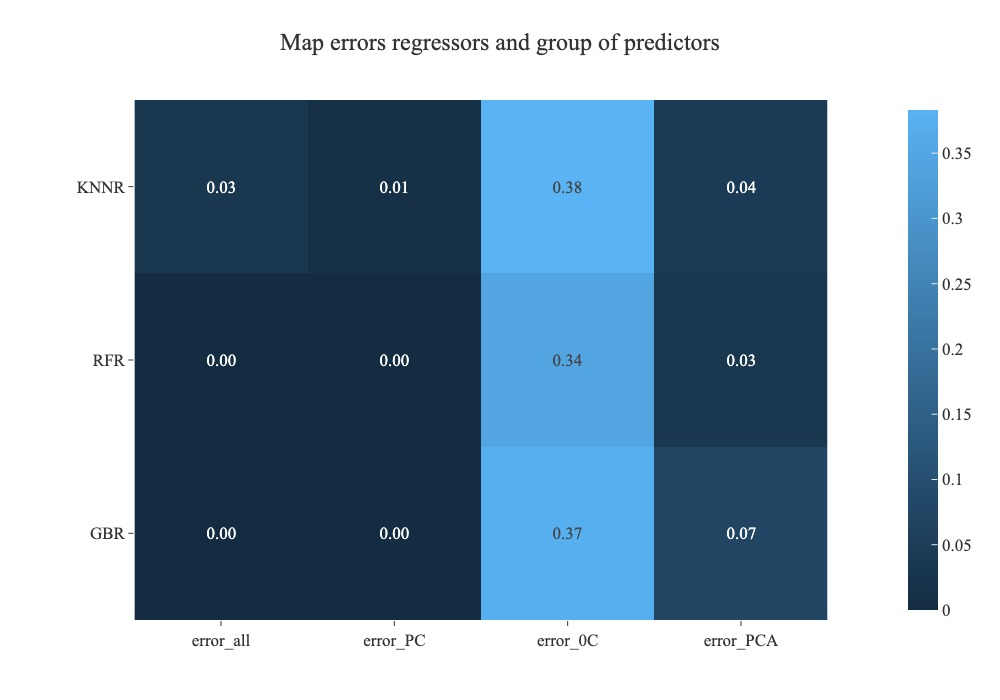

In [59]:
# построим тепловую карту для наглядности
fig = px.imshow(error_by_regressor, 
                text_auto='.2f',
                width=1000,
                height=700,
                title='Map errors regressors and group of predictors',
                template='ggplot2',
               )

# Настройка шрифта и наклона категорий оси х
fig.update_layout( 
                  font = dict(size=17, 
                              family="TimesNewRoman"
                             )
                 )

fig.show('jpeg');

<hr style="border-style: dashed;">

__Вывод:__
- При использование датафрейма с нормализованными данными, конечный результат остался такой же, так что было принято решение использовать оригинальный датафрейм.
- Лучшей моделью у нас оказался Метод k-ближайших соседей (KNNR), он показал нам ошибку в 1% когда мы использовали предикторы с положительной сильной корреляцией и в 3% когда использовали все предикторы.
- Случайный лес для регрессии  и Градиентный бустинг при использование всех предикторов и предикторов с положительной сильной корреляцией скорее всего переобучились и на реальных данных будут давать плохой результат.
- Довольно хорошо себя показали предикторы PCA на всех регрессиях
- Предикторы со слабой связью дали самый плохой результат более 30% ошибок, в принципе так и должно быть.

<hr style="border-style: dashed;">